In [1]:
import os # currently used for pathing

from bs4 import BeautifulSoup # currently used for parsing SGML format

import pandas as pd

import re # regex, currently used for cleaning

import html # currently used for cleaning

from sklearn.preprocessing import MultiLabelBinarizer # currently used for one-hot encoding

import numpy as np

from skmultilearn.model_selection import iterative_train_test_split # splitting data, using iterative split module for stratified splitting given prevalence of labels with only 2 associated documents

from transformers import BertTokenizer # currently used for tokenizing input

import torch # currently used for converting one-hot encoded topics into PyTorch tensor

from torch.utils.data import Dataset, DataLoader # currently used for feeding data into the model in batches.

from transformers import BertForSequenceClassification # import for the BERT model. This one in particular is the sequence-classification model, which is just BERT with an additional classification layer on top. More suitable for Document Classification.

from transformers import AdamW, get_linear_schedule_with_warmup # Using AdamW as our optimizer, adding learning rate scheduler to adjust learning rate during training

from torch import nn # neural network module from PyTorch. We're retrieving our loss function from the nn module.
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # metrics

In [2]:
relative_path = os.path.join('Datasets', 'reuters21578')

In [3]:
sgml_files = [os.path.join(relative_path, f) for f in os.listdir(relative_path) if f.endswith('.sgm')]

In [4]:
# Checking for presence of all .sgm files.

sgml_files

['Datasets\\reuters21578\\reut2-000.sgm',
 'Datasets\\reuters21578\\reut2-001.sgm',
 'Datasets\\reuters21578\\reut2-002.sgm',
 'Datasets\\reuters21578\\reut2-003.sgm',
 'Datasets\\reuters21578\\reut2-004.sgm',
 'Datasets\\reuters21578\\reut2-005.sgm',
 'Datasets\\reuters21578\\reut2-006.sgm',
 'Datasets\\reuters21578\\reut2-007.sgm',
 'Datasets\\reuters21578\\reut2-008.sgm',
 'Datasets\\reuters21578\\reut2-009.sgm',
 'Datasets\\reuters21578\\reut2-010.sgm',
 'Datasets\\reuters21578\\reut2-011.sgm',
 'Datasets\\reuters21578\\reut2-012.sgm',
 'Datasets\\reuters21578\\reut2-013.sgm',
 'Datasets\\reuters21578\\reut2-014.sgm',
 'Datasets\\reuters21578\\reut2-015.sgm',
 'Datasets\\reuters21578\\reut2-016.sgm',
 'Datasets\\reuters21578\\reut2-017.sgm',
 'Datasets\\reuters21578\\reut2-018.sgm',
 'Datasets\\reuters21578\\reut2-019.sgm',
 'Datasets\\reuters21578\\reut2-020.sgm',
 'Datasets\\reuters21578\\reut2-021.sgm']

# Extracting relevant data from Reuters-21578.

The reuters-21578 dataset is structured in SGML format. What will be column headers are differentiated via XML tags. This is evident if you print out the results of 'file.read()'. For our first classification model, we will be using BERT. Given this, we are mainly interested in the 'title' and 'body' tags for tokenization and later input. In addition to tokenizing text and titles, we are also interested in preparing labels. The labels for each document in this dataset are conveniently indicated by the 'topics' tag.

It should be noted that the 'body' tag seems to disappear after we have parsed via BeautifulSoup. To work around this, we have simply replaced the 'body' opening and closing tags with the 'content' tag (which can be parsed via BeautifulSoup).

In [5]:
# Function to extract document text and topics where the 'topics' field of the 'REUTERS' tag is set to 'YES'
def extract_reuters_data(sgml_file):
    with open(sgml_file, 'r', encoding='latin-1') as file: # ? Why latin-1 as our encoding parameter?
        content = file.read()
    content = content.replace('<BODY>', '<CONTENT>').replace('</BODY>', '</CONTENT>')
    soup = BeautifulSoup(content, 'lxml') # ? Why 'lxml'?
    
    documents = []
    for reuters in soup.find_all('reuters'):
        if reuters.get('topics') == 'YES':
            topics = [topic.text for topic in reuters.topics.find_all('d')] if reuters.topics else []
            title = reuters.find('title').text if reuters.find('title') else ''
            body = reuters.find('content').text if reuters.find('content') else ''

            documents.append({'topics': topics, 'title': title, 'body' : body})
    return documents

In [6]:
# Extract all documents from the SGML files in the relative path
all_documents = []
for sgml_file in sgml_files:
    all_documents.extend(extract_reuters_data(sgml_file))

# Convert the list of documents to a dataframe
df = pd.DataFrame(all_documents)

# Display the first few rows of the dataframe
df.head()

,topics,title,body
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show\ncrop regis...
3,[],USX <X> DEBT DOWGRADED BY MOODY'S,Moody's Investors Service Inc said it\nlowered...
4,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its\nboard of direc...


# Data Cleaning

In [7]:
# 1. Remove newline characters
df['body'] = df['body'].str.replace('\n', ' ', regex=False)
df['title'] = df['title'].str.replace('\n', ' ', regex=False)

In [8]:
# 2. Remove extra spaces
df['body'] = df['body'].apply(lambda x: ' '.join(x.split()))
df['title'] = df['title'].apply(lambda x: ' '.join(x.split()))

In [9]:
# 3. Optionally, convert to lowercase
# df['body'] = df['body'].str.lower()
# df['title'] = df['title'].str.lower()

In [10]:
# 4. Optionally, filter out short documents
# df = df[df['body'].apply(lambda x: len(x.split()) > 10)]

In [11]:
# 5. Handle HTML/SGML entities
df['body'] = df['body'].apply(html.unescape)
df['title'] = df['title'].apply(html.unescape)

In [12]:
# 6. Combine title and text columns together

df['combined_text'] = df['title'] + " " + df['body']

In [13]:
df

,topics,title,body,combined_text
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...
3,[],USX <X> DEBT DOWGRADED BY MOODY'S,Moody's Investors Service Inc said it lowered ...,USX <X> DEBT DOWGRADED BY MOODY'S Moody's Inve...
4,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...
...,...,...,...,...
13471,[acq],N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will make an ...,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH ...
13472,"[money-fx, dlr, yen]",TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 YEN,Tokyo's foreign exchange market is watching ne...,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...
13473,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan shipping c...,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHAR...
13474,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is growin...,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987 ...


In [14]:
# 7. Check for any rows with missing and/or nan/null titles or bodies, as well as severely diminished title + body combinations. Remove them.

missing_combined_text = df[df['combined_text'].isnull()]
empty_texts = df[df['combined_text'].str.replace(' ', '', regex=False).str.len() <= 26]
print(len(missing_combined_text))
print(empty_texts)

# No null or NaN values detected, as such, we only need to mask those rows with empty values in the combined_text column

df = df[~(df['combined_text'].str.replace(' ', '', regex=False).str.len() <= 26)]

# Notes:

# After combining title and body texts, and removing all spaces, we can see that there are 737 documents without anything in the combined text column. The shortest value in the combined_text column has a length of 27. Anything below a length of 27 is simply blank, as both the condition '<=0' and the condition '<=26' return 737 rows.

0
               topics title body combined_text
68     [money-supply]                         
70     [money-supply]                         
71     [money-supply]                         
72     [money-supply]                         
93     [money-supply]                         
...               ...   ...  ...           ...
12777   [trade, jobs]                         
13136          [earn]                         
13180         [crude]                         
13194           [acq]                         
13267          [earn]                         

[69 rows x 4 columns]


In [15]:
# 8. Remove documents with no labels

empty_topics = df[df['topics'].apply(lambda x: len(x) == 0 if isinstance(x, list) else True)]
print(len(empty_topics.index))
df = df.drop(empty_topics.index)
df.reset_index(drop=True, inplace=True)
df

2110


,topics,title,body,combined_text
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...
3,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...
4,[acq],COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SAL...
...,...,...,...,...
11292,[acq],N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will make an ...,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH ...
11293,"[money-fx, dlr, yen]",TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 YEN,Tokyo's foreign exchange market is watching ne...,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...
11294,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan shipping c...,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHAR...
11295,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is growin...,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987 ...


In [16]:
# 9. Removing those labels without at least five associated documents in the dataset.

topic_counts = df['topics'].explode().value_counts()
invalid_topics = topic_counts[topic_counts<5].index.tolist()
print(topic_counts)
print(invalid_topics)
df['topics'] = df['topics'].apply(lambda topics_list: [label for label in topics_list if label not in invalid_topics])
df_clean = df[df['topics'].apply(len) > 0].reset_index(drop=True)

topics
earn          3963
acq           2445
money-fx       794
crude          625
grain          621
              ... 
skr              1
rupiah           1
peseta           1
castorseed       1
red-bean         1
Name: count, Length: 119, dtype: int64
['cpu', 'austdlr', 'nzdlr', 'tapioca', 'plywood', 'pork-belly', 'rand', 'lit', 'nkr', 'f-cattle', 'cotton-oil', 'saudriyal', 'dfl', 'can', 'palladium', 'palmkernel', 'copra-cake', 'sfr', 'fishmeal', 'lin-oil', 'sun-meal', 'linseed', 'castor-oil', 'rye', 'groundnut-oil', 'cornglutenfeed', 'wool', 'corn-oil', 'rape-meal', 'hk', 'bfr', 'cottonseed', 'lin-meal', 'citruspulp', 'dkr', 'ringgit', 'skr', 'rupiah', 'peseta', 'castorseed', 'red-bean']


In [17]:
# Double checking to make sure none of the single-document topics still remain in any of the lists in the topics column
df_clean['topics'].apply(lambda topics_list: all(label not in invalid_topics for label in topics_list)).value_counts()

topics
True    11290
Name: count, dtype: int64

In [18]:
# Triple Checking
topic_counts = df_clean['topics'].explode().value_counts()
topic_counts

topics
earn           3963
acq            2445
money-fx        794
crude           625
grain           621
               ... 
inventories       7
naphtha           7
potato            6
propane           6
coconut           6
Name: count, Length: 78, dtype: int64

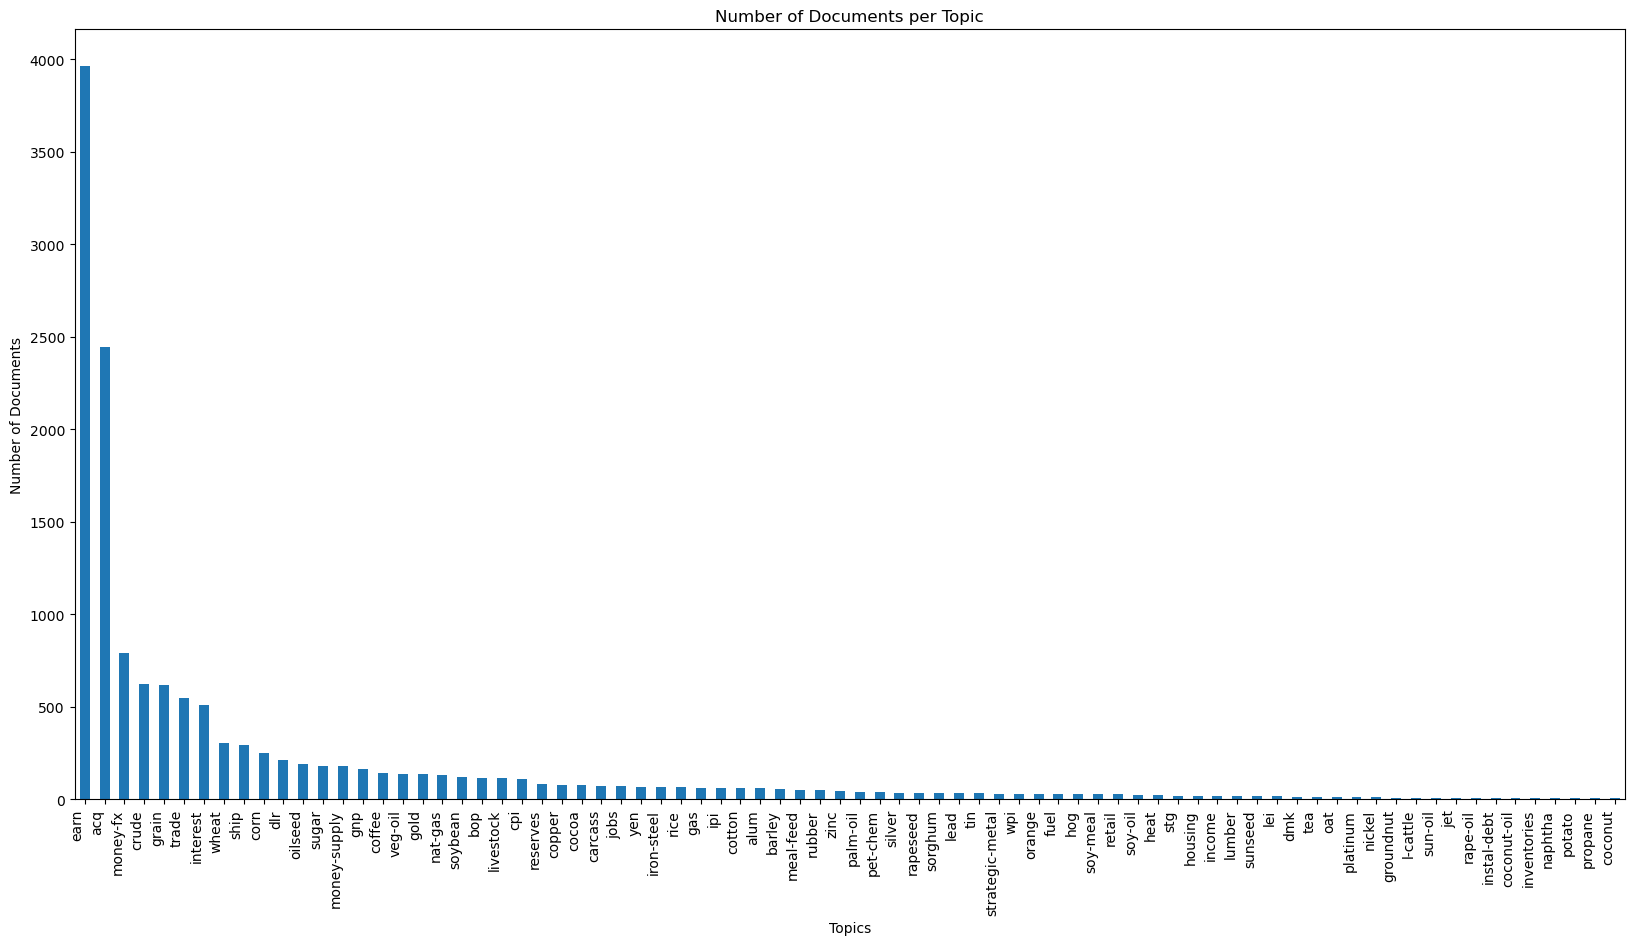

In [19]:
import matplotlib.pyplot as plt

# Bar chart of the number of documents per topic after removing those topics with less than two documents associated
plt.figure(figsize=(20,10))
topic_counts.plot(kind='bar')
plt.title('Number of Documents per Topic')
plt.xlabel('Topics')
plt.ylabel('Number of Documents')
plt.xticks(rotation=90, ha='right')
plt.show()

# One-hot encoding topics column

In [20]:
# Create the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# One-hot encode the 'topics' column
one_hot_topics = mlb.fit_transform(df_clean['topics'])

# Get the list of all topic names (column names)
topic_names = mlb.classes_

# Convert the one-hot encoded topics back into a dataframe
one_hot_df = pd.DataFrame(one_hot_topics, columns=topic_names)

# Concatenate the one-hot encoded topics with the original dataframe
df_one_hot = pd.concat([df_clean, one_hot_df], axis=1)

# Display the first few rows of the updated dataframe
df_one_hot.head()

,topics,title,body,combined_text,acq,alum,barley,bop,carcass,cocoa,...,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,"[veg-oil, soy-oil, sun-oil, soybean, oilseed, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...,0,0,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0
3,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[acq],COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SAL...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting Data

In [21]:
# Extract the combined text and one-hot encoded labels
X = df_one_hot['combined_text'].values  # Combined text (input features)
y = df_one_hot[df_one_hot.columns.difference(['title', 'body', 'topics', 'combined_text'])].values  # One-hot encoded topics (labels)

# Reshape X to 2D as required by iterative_train_test_split
X = np.array(X).reshape(-1, 1) 

# Perform iterative stratified split (80% training, 20% testing)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

# Reshape X_train, X_test back to 1D arrays for tokenization
X_train = X_train.ravel()
X_test = X_test.ravel()

# Check the resulting sizes
print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")


Training Set: 9031 samples
Testing Set: 2259 samples


In [22]:
label_names = df_one_hot.columns.difference(['title', 'body', 'topics', 'combined_text'])

In [23]:
label_names

Index(['acq', 'alum', 'barley', 'bop', 'carcass', 'cocoa', 'coconut',
       'coconut-oil', 'coffee', 'copper', 'corn', 'cotton', 'cpi', 'crude',
       'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain',
       'groundnut', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'inventories', 'ipi', 'iron-steel', 'jet', 'jobs',
       'l-cattle', 'lead', 'lei', 'livestock', 'lumber', 'meal-feed',
       'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'oat',
       'oilseed', 'orange', 'palm-oil', 'pet-chem', 'platinum', 'potato',
       'propane', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice',
       'rubber', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'stg', 'strategic-metal', 'sugar', 'sun-oil', 'sunseed', 'tea', 'tin',
       'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc'],
      dtype='object')

In [24]:
# Function to check label distribution
def check_label_distribution(y, label_names):
    label_counts = np.sum(y, axis=0)  # Sum the one-hot encoded labels along axis 0
    label_distribution = dict(zip(label_names, label_counts))  # Create a dictionary mapping label names to counts
    return label_distribution

In [25]:
# Checking distribution of labels in our training set
train_label_distribution = check_label_distribution(y_train, label_names)
print("Training Set Label Distribution:")
zero_count_labels_train = []
for label, count in train_label_distribution.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_train.append(label)
print(zero_count_labels_train)
    


Training Set Label Distribution:
acq: 1956 occurrences
alum: 50 occurrences
barley: 42 occurrences
bop: 93 occurrences
carcass: 60 occurrences
cocoa: 61 occurrences
coconut: 4 occurrences
coconut-oil: 6 occurrences
coffee: 116 occurrences
copper: 62 occurrences
corn: 201 occurrences
cotton: 50 occurrences
cpi: 90 occurrences
crude: 500 occurrences
dlr: 173 occurrences
dmk: 12 occurrences
earn: 3170 occurrences
fuel: 22 occurrences
gas: 51 occurrences
gnp: 130 occurrences
gold: 108 occurrences
grain: 497 occurrences
groundnut: 8 occurrences
heat: 20 occurrences
hog: 22 occurrences
housing: 17 occurrences
income: 14 occurrences
instal-debt: 6 occurrences
interest: 407 occurrences
inventories: 6 occurrences
ipi: 51 occurrences
iron-steel: 54 occurrences
jet: 6 occurrences
jobs: 59 occurrences
l-cattle: 7 occurrences
lead: 28 occurrences
lei: 14 occurrences
livestock: 91 occurrences
lumber: 14 occurrences
meal-feed: 41 occurrences
money-fx: 635 occurrences
money-supply: 146 occurrences
nap

In [26]:
# Check the distribution of labels for our testing set
test_label_distribution = check_label_distribution(y_test, label_names)
print("\nTesting Set Label Distribution:")
zero_count_labels_test = []
for label, count in test_label_distribution.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_test.append(label)
print(zero_count_labels_test)


Testing Set Label Distribution:
acq: 489 occurrences
alum: 12 occurrences
barley: 12 occurrences
bop: 23 occurrences
carcass: 15 occurrences
cocoa: 15 occurrences
coconut: 2 occurrences
coconut-oil: 1 occurrences
coffee: 29 occurrences
copper: 16 occurrences
corn: 50 occurrences
cotton: 13 occurrences
cpi: 22 occurrences
crude: 125 occurrences
dlr: 43 occurrences
dmk: 3 occurrences
earn: 793 occurrences
fuel: 6 occurrences
gas: 13 occurrences
gnp: 33 occurrences
gold: 27 occurrences
grain: 124 occurrences
groundnut: 2 occurrences
heat: 5 occurrences
hog: 5 occurrences
housing: 4 occurrences
income: 4 occurrences
instal-debt: 1 occurrences
interest: 102 occurrences
inventories: 1 occurrences
ipi: 13 occurrences
iron-steel: 13 occurrences
jet: 2 occurrences
jobs: 15 occurrences
l-cattle: 2 occurrences
lead: 7 occurrences
lei: 3 occurrences
livestock: 23 occurrences
lumber: 3 occurrences
meal-feed: 10 occurrences
money-fx: 159 occurrences
money-supply: 36 occurrences
naphtha: 1 occurrenc

# Tokenizing text and turning topics into PyTorch tensor

In [27]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize the text data #
def tokenize_texts(texts, max_length=512):
    return tokenizer(
        texts.tolist(),           # List of text to be tokenized
        padding=True,             # Add padding to make all sequences the same length
        truncation=True,          # Truncate texts that are too long
        max_length=max_length,    # Maximum length of each input sequence
        return_tensors='pt'       # Return PyTorch tensors
    )

# Tokenize the text in the dataframe
X_train_tokenized = tokenize_texts(X_train)
X_test_tokenized = tokenize_texts(X_test)

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

C:\Users\Manlai\anaconda3\envs\TextClassification\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Manlai\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [28]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.astype(float))
test_labels = torch.tensor(y_test.astype(float))

# Custom dataset class extending PyTorch's 'Dataset' class.
class DocumentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create training and testing datasets
train_dataset = DocumentDataset(X_train_tokenized, train_labels)
test_dataset = DocumentDataset(X_test_tokenized, test_labels)

# Create DataLoader for batching
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Initializing BERT Model and defining Optimizer

In [29]:
# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=y_train.shape[1],  # Number of labels for multi-label classification, should be fine since our training set encompasses all the different labels that will appear in our dataset.
    problem_type="multi_label_classification"
)

# Move model to GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set up a learning rate scheduler
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

C:\Users\Manlai\anaconda3\envs\TextClassification\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# TRAINING WITHOUT VALIDATION SET

In [31]:
# Set up loss function for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataloader:
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'].float())  # Use float() for multi-label

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_dataloader)}")


Epoch 1/5, Loss: 0.14613609617262815
Epoch 2/5, Loss: 0.05437109712346465
Epoch 3/5, Loss: 0.04275363316446279
Epoch 4/5, Loss: 0.03640951817377215
Epoch 5/5, Loss: 0.03313266952909463


In [32]:
model.eval()

all_preds = []
all_labels = []
total_test_loss = 0
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'].float())
        total_test_loss += loss.item()
    preds = torch.sigmoid(outputs.logits).cpu().numpy()  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).astype(int)  # Threshold to get binary predictions
    all_preds.append(preds)
    all_labels.append(batch['labels'].cpu().numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='micro')
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
print(f"Test F1 Score: {f1}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


Test F1 Score: 0.6946270686919067
Test Accuracy: 0.5781319167773351
Test Precision: 0.9677826910928616
Test Recall: 0.5417256011315418
